In [285]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn import metrics
from scipy.stats import multivariate_normal
from random import sample 
import seaborn as sb

In [66]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [378]:
###
# Parameters:
# mean: mean of the distribution
# cov: covariance of the distribution
# @size: default is 10, the number of wanted samples
# @plot: default is False, whether to plot confidence elipse or not
#
# Returns:
# mean_cosine_similarity: estimation to how much the covariance is simular to the original covariance
# cov_cosine_similarity estimation to how much the mean is simular to the original mean
def multivariate_normal_test(mean, cov, size=10, plot=False):
    
    
    
    # sample given size from 2D gaussian distribution
    samples = np.random.multivariate_normal(mean, cov, size=size)
    
    
    x = samples[:,0]
    y = samples[:,1]
    
    # plot the samples
    if plot:
        fig = plt.figure(figsize=(8,8))
        ax = fig.gca()
        ax.scatter(x, y)
        #plot elipse
        confidence_ellipse(x, y, ax, edgecolor='red')
    
    # estimate new mean and covariance using the samples
    newmean = np.array([np.mean(x), np.mean(y)])
    newcov = np.cov(samples.T)
    
    # measure the estimation accuracy using cosine similarity method
    cov_cosine_similarity = metrics.pairwise.cosine_similarity(newcov, cov)
    mean_cosine_similarity = metrics.pairwise.cosine_similarity([newmean], [mean])
    sim = (mean_cosine_similarity[0][0]*np.linalg.det(cov_cosine_similarity))*2
    return (sim, newmean, newcov)

Estimated mean is:[-0.49990116  2.47530803], Estimated cov is:[[2.5550523  0.65708925]
 [0.65708925 1.56823685]]
Similarty evaluation is:1.0784658067508592


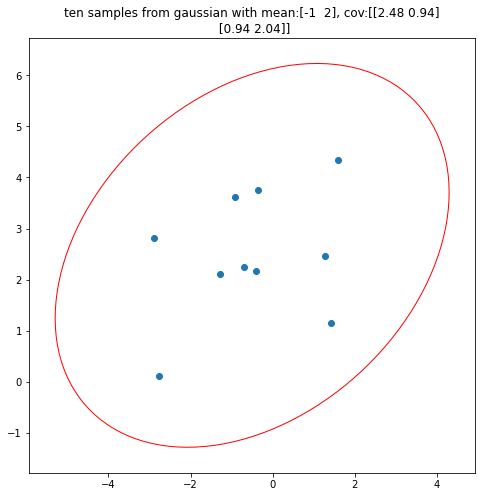

In [381]:
# 2A
# mean vector
mean = np.array([-1, 2])
# covariance matrix
cov = np.array([[2.48, 0.94],[0.94, 2.04]])
sim, nmean, ncov = multivariate_normal_test(mean, cov, plot=True)
plt.title("ten samples from gaussian with mean:{}, cov:{}".format(mean, cov))
plt.savefig("multiGaussSamples.png")
# 2B
print("Estimated mean is:{}, Estimated cov is:{}".format(nmean, ncov))
print("Similarty evaluation is:{}".format(sim)) 

Cosine similarity, or the cosine kernel, computes similarity as the
normalized dot product of X and Y:

    K(X, Y) = <X, Y> / (||X||*||Y||)
   

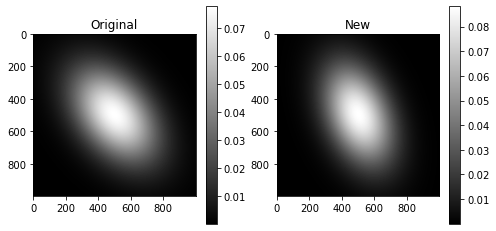

In [360]:
# 2c

# number of samples
samples = 1000
length = 4
stepX = (2*length)/samples
stepY = (2*length)/samples
# create matrix of equaly divided x and y values
x, y = np.mgrid[mean[0]-length:mean[0]+length:stepX, mean[1]-length:mean[1]+length:stepX]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
plt.figure(figsize=(8,4))
plt.subplot(121)
# create probability distribution
origpos = rv.pdf(pos)
plt.imshow(origpos, cmap='gray')
plt.title("Original")
plt.colorbar()
plt.savefig("originalDistribution.png")
stepX = (2*length)/samples
stepY = (2*length)/samples
x, y = np.mgrid[newmean[0]-length:newmean[0]+length:stepX, newmean[1]-length:newmean[1]+length:stepX]
pos = np.dstack((x, y))
rv = multivariate_normal(newmean, newcov)
plt.subplot(122)
# create probability distribution
newpos = rv.pdf(pos)
plt.imshow(newpos, cmap='gray')
plt.title("New")
plt.colorbar()
plt.savefig("estimatedDistribution.png")

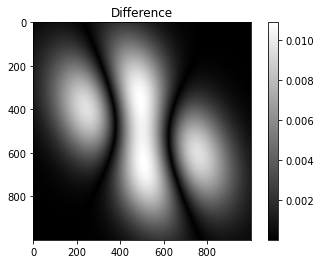

In [361]:
diff = abs(origpos - newpos)
plt.imshow(diff, cmap='gray')
plt.title("Difference")
plt.colorbar()
plt.savefig("Distributions difference.png")

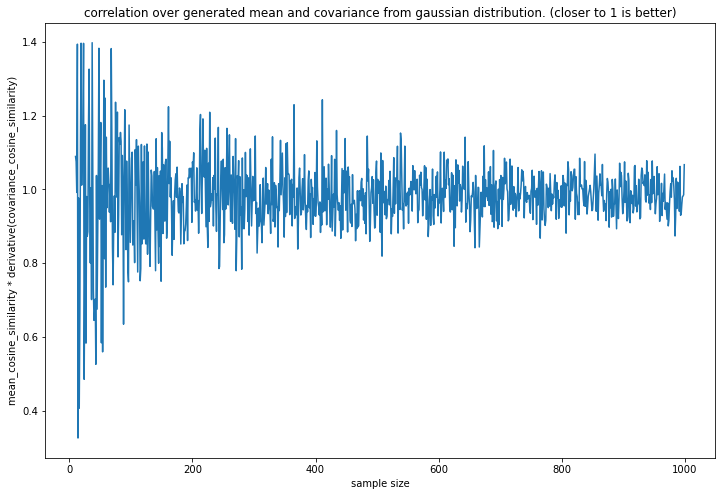

In [383]:
# 2d

mean_cosine_similarity = []
cov_cosine_similarity = []
similarity = []
sizes = range(10, 1000)
# iterate from 10 samples to 1000 and measure the similarity between the estimated and original
for size in sizes:
    sim, nmean, ncov = multivariate_normal_test(mean, cov, size)
    #mean_cosine_similarity.append(x)
    #cov_cosine_similarity.append(np.linalg.det(y))
    # the similarity parameter is the derivative of cosine similarity multiplied over the mean and cov to create unified measure
    similarity.append(sim)


plt.figure(figsize=(12, 8))
plt.plot(sizes, similarity)
plt.title("correlation over generated mean and covariance from gaussian distribution. (closer to 1 is better)")
plt.ylabel("mean_cosine_similarity * derivative(covariance_cosine_similarity)")
plt.xlabel("sample size")
plt.savefig("correlation over generated mean and covariance from gaussian distribution.png")